In [43]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import joblib
import numpy as np


In [44]:
# dataset_dir = 'sentiment140'
# dataset_dir = 'imdb'
dataset_dir = 'coronaNLP'

max_f = 50
# max_f = 30
max_f = 20
max_f_str = str(max_f) + 'k'

# n_gram = (1, 1)
n_gram = (1, 2)
# n_gram = (2, 2)

# importing the processed dataframe
df = joblib.load(f'./dataframes/df_{dataset_dir}.pkl')


df.head()



,OriginalTweet,Sentiment
0,gahan,0
1,advic talk neighbour famili exchang phone numb...,1
2,coronavirus australia woolworth give elder dis...,1
3,food stock onli one empti pleas dont panic eno...,1
4,readi go supermarket dure covid19 outbreak bec...,-2


In [45]:

X = df.iloc[:, 0]


y = df.iloc[:, 1]

X, y

(0                                                    gahan
 1        advic talk neighbour famili exchang phone numb...
 2        coronavirus australia woolworth give elder dis...
 3        food stock onli one empti pleas dont panic eno...
 4        readi go supermarket dure covid19 outbreak bec...
                                ...                        
 41152    airlin pilot offer stock supermarket shelv nz ...
 41153    respons complaint provid cite covid19 relat de...
 41154    know itâ get tough ration toilet paper corona...
 41155    wrong smell hand sanit start turn coronavirus ...
 41156    well newus rift go 70000 amazon rn although no...
 Name: OriginalTweet, Length: 41157, dtype: object,
 0        0
 1        1
 2        1
 3        1
 4       -2
         ..
 41152    0
 41153   -2
 41154    1
 41155    0
 41156   -1
 Name: Sentiment, Length: 41157, dtype: int32)

In [46]:


tfidf = joblib.load(
    f"./vectors/vectorizer_{max_f_str}_{dataset_dir}_{n_gram}.pkl")
tfidf

TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)

In [47]:

X = tfidf.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((32925, 20000), (32925,))

C:\Users\Enes\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

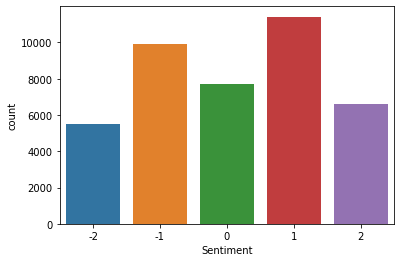

In [48]:
sns.countplot(y)

Text(0.5, 1.0, 'Positive words cloud')

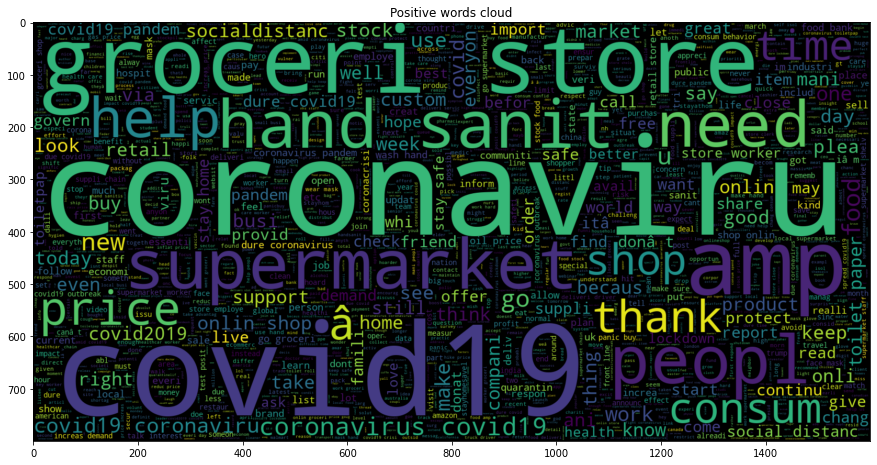

In [49]:
plt.figure(figsize = (15,15)) 
options = [1, 2]
cond = df.iloc[:, 1].isin(options)
result = df[cond].iloc[:, 0].values
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(result))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Positive words cloud')

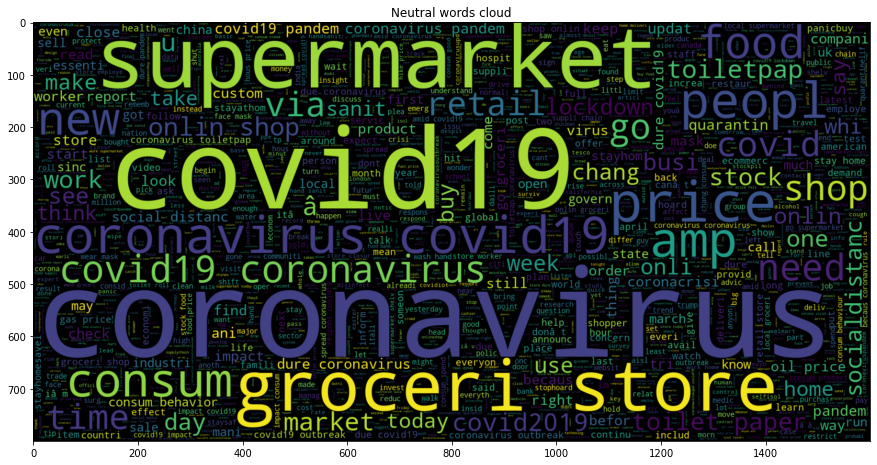

In [50]:
if dataset_dir == 'coronaNLP':
    plt.figure(figsize=(15, 15))
    options = [0]
    cond = df.iloc[:, 1].isin(options)
    result = df[cond].iloc[:, 0].values
    wc = WordCloud(max_words=2000, width=1600,
                height=800).generate(" ".join(result))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Neutral words cloud')


Text(0.5, 1.0, 'Negative words cloud')

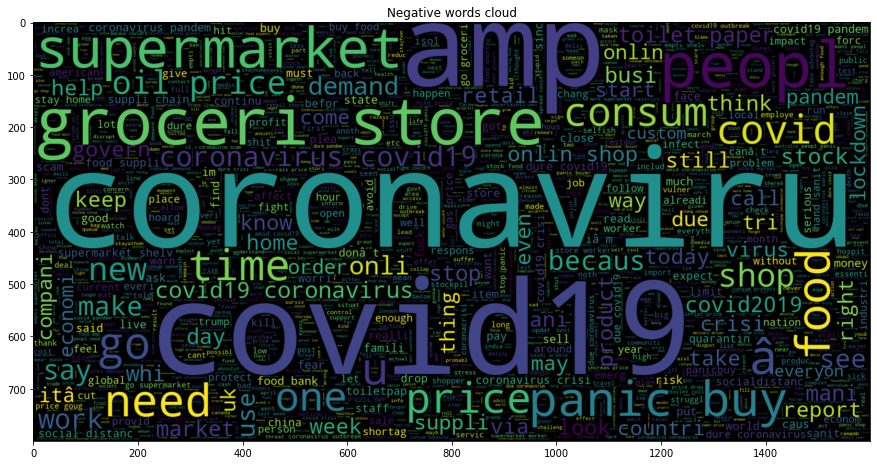

In [51]:
plt.figure(figsize=(15, 15))
options = [-1, -2]
cond = df.iloc[:, 1].isin(options)
result = df[cond].iloc[:, 0].values
wc = WordCloud(max_words=2000, width=1600,
               height=800).generate(" ".join(result))
plt.imshow(wc, interpolation='bilinear')
plt.title('Negative words cloud')


In [52]:

# creating our pipeline that will return an estimator
pipeline = Pipeline([('clf', MultinomialNB())])


In [53]:

parameters = {
    'clf__fit_prior': (False, True),
    'clf__alpha': (1, 0.1, 0.01, 0.001)
    }

clf = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy', cv=5, verbose=1)
clf

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', MultinomialNB())]),
             param_grid={'clf__alpha': (1, 0.1, 0.01, 0.001),
                         'clf__fit_prior': (False, True)},
             scoring='accuracy', verbose=1)

In [54]:

clf = clf.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [61]:

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.53      0.44      0.48      1056
          -1       0.43      0.47      0.45      2006
           0       0.59      0.49      0.54      1553
           1       0.44      0.50      0.47      2287
           2       0.51      0.48      0.50      1330

    accuracy                           0.48      8232
   macro avg       0.50      0.48      0.49      8232
weighted avg       0.49      0.48      0.48      8232



Pipeline(steps=[('clf', MultinomialNB(alpha=1, fit_prior=False))])

In [62]:

print("Best: %f using %s" % (clf.best_score_, 
    clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.470402 using {'clf__alpha': 1, 'clf__fit_prior': False}
0.470402 (0.008899) with: {'clf__alpha': 1, 'clf__fit_prior': False}
0.427882 (0.005884) with: {'clf__alpha': 1, 'clf__fit_prior': True}
0.448292 (0.007793) with: {'clf__alpha': 0.1, 'clf__fit_prior': False}
0.448200 (0.007695) with: {'clf__alpha': 0.1, 'clf__fit_prior': True}
0.426454 (0.008630) with: {'clf__alpha': 0.01, 'clf__fit_prior': False}
0.428428 (0.009826) with: {'clf__alpha': 0.01, 'clf__fit_prior': True}
0.412756 (0.009467) with: {'clf__alpha': 0.001, 'clf__fit_prior': False}
0.416006 (0.009323) with: {'clf__alpha': 0.001, 'clf__fit_prior': True}


In [57]:

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

acc = int(accuracy_score(y_test, y_pred)*100)


[[ 462  436   29  114   15]
 [ 292  950  209  454  101]
 [  55  293  766  364   75]
 [  49  433  246 1141  418]
 [  16   86   50  534  644]]


In [58]:

# exporting the pipeline
joblib.dump(df, f'./models/mnb_{dataset_dir}_{acc}.pkl')

['./models/mnb_coronaNLP_48.pkl']